### Import necessary libraries
In this first cell, we import the necessary Python libraries for spatial data manipulation, querying OpenStreetMap (OSM) data, and plotting.

In [1]:
# Import necessary libraries
import overpy
import geopandas as gpd
from shapely.geometry import Polygon, MultiPolygon, LineString, Point
from shapely.ops import unary_union, linemerge
from shapely.validation import make_valid
from shapely.errors import TopologicalError
import matplotlib.pyplot as plt
import networkx as nx
import contextily as cx
import plotly.graph_objects as go
import math
%matplotlib widget

### Helper functions
We define some key helper functions used in processing building geometries and calculating the midpoints of building facades.

In [2]:
# Helper function to close small gaps between lines
def close_small_gaps(line, tolerance=0.0001):
    if line.is_ring:  # Already closed
        return line
    # Check if the start and end points are within the tolerance
    if line.coords[0] != line.coords[-1]:
        start = line.coords[0]
        end = line.coords[-1]
        if LineString([start, end]).length <= tolerance:
            coords = list(line.coords)
            coords[-1] = start
            return LineString(coords)
    return line

# Function to get facade midpoints for each building's polygon
def get_facade_midpoints_per_building(geometry, building_id):
    midpoints = []
    
    # Handle MultiPolygon by iterating over each Polygon
    if geometry.geom_type == 'MultiPolygon':
        for polygon in geometry.geoms:
            exterior_coords = list(polygon.exterior.coords)
            
            # Process each edge of the polygon and compute its midpoint
            for i in range(len(exterior_coords) - 1):
                p1 = exterior_coords[i]
                p2 = exterior_coords[i + 1]
                
                # Create midpoint
                midpoint = Point((p1[0] + p2[0]) / 2, (p1[1] + p2[1]) / 2)
                
                # Store facade midpoint data
                midpoints.append({
                    'building_id': building_id, 
                    'geometry': midpoint, 
                    'facade_index': i
                })
    # Handle single Polygon
    elif geometry.geom_type == 'Polygon':
        exterior_coords = list(geometry.exterior.coords)
        
        # Process each edge of the polygon and compute its midpoint
        for i in range(len(exterior_coords) - 1):
            p1 = exterior_coords[i]
            p2 = exterior_coords[i + 1]
            
            # Create midpoint
            midpoint = Point((p1[0] + p2[0]) / 2, (p1[1] + p2[1]) / 2)
            
            # Store facade midpoint data
            midpoints.append({
                'building_id': building_id, 
                'geometry': midpoint, 
                'facade_index': i
            })
    
    return midpoints


# Function to process OSM building elements and extract geometries
def process_building(element):
    outer_ways, inner_ways = [], []  # Initialize as two empty lists
    
    # Process relations
    if isinstance(element, overpy.Relation):
        for member in element.members:
            if isinstance(member, (overpy.Way, overpy.RelationWay)): 
                if member.role == 'outer':
                    outer_ways.append(member)
                elif member.role == 'inner':
                    inner_ways.append(member)

        if not outer_ways:
            return None  # Skip if no outer ways

        outer_polygons, outer_lines = [], []
        for outer_way in outer_ways:
            if isinstance(outer_way, overpy.RelationWay):
                outer_way = outer_way.resolve()

            nodes = [(float(node.lon), float(node.lat)) for node in outer_way.nodes]
            if len(nodes) >= 2:
                line = LineString(nodes)
                outer_lines.append(line)

        try:
            merged_line = linemerge(outer_lines)
            if isinstance(merged_line, LineString):
                merged_line = close_small_gaps(merged_line)
                if merged_line.is_ring:
                    outer_polygon = Polygon(merged_line)
                    if outer_polygon.is_valid:
                        outer_polygons.append(outer_polygon)
                    else:
                        outer_polygon = make_valid(outer_polygon)
                        if outer_polygon.is_valid:
                            outer_polygons.append(outer_polygon)
            elif isinstance(merged_line, MultiPolygon):
                outer_polygons = list(merged_line.geoms)
            else:
                outer_polygons = [Polygon(line) for line in outer_lines if line.is_ring and Polygon(line).is_valid]
        except TopologicalError as e:
            outer_polygons = [Polygon(line) for line in outer_lines if line.is_ring and Polygon(line).is_valid]

        if not outer_polygons:
            return None

        if len(outer_polygons) > 1:
            geometry = max(outer_polygons, key=lambda p: p.area)
        else:
            geometry = outer_polygons[0]

        # Add holes (inner polygons)
        inner_polygons = []
        for inner_way in inner_ways:
            if isinstance(inner_way, overpy.RelationWay):
                inner_way = inner_way.resolve()

            nodes = [(float(node.lon), float(node.lat)) for node in inner_way.nodes]
            if len(nodes) >= 4:
                if nodes[0] != nodes[-1]:
                    nodes.append(nodes[0])
                inner_polygon = Polygon(nodes)
                if inner_polygon.is_valid:
                    inner_polygons.append(inner_polygon)

        try:
            geometry = Polygon(geometry.exterior.coords, holes=[inner.exterior.coords for inner in inner_polygons if geometry.contains(inner)])
        except TopologicalError as e:
            return None

        if not geometry.is_valid:
            geometry = geometry.buffer(0)
            if not geometry.is_valid:
                return None

    # Simple polygons (for ways)
    else:
        nodes = [(float(node.lon), float(node.lat)) for node in element.nodes]
        if len(nodes) >= 4:
            if nodes[0] != nodes[-1]:
                nodes.append(nodes[0])
            try:
                geometry = Polygon(nodes)
                if not geometry.is_valid:
                    geometry = geometry.buffer(0)
                    if not geometry.is_valid:
                        return None
            except TopologicalError as e:
                return None
        else:
            return None

    height = element.tags.get('height')
    levels = element.tags.get('building:levels')
    building_type = element.tags.get('building')
    name = element.tags.get('name')

    if height:
        try:
            height = float(height)
        except ValueError:
            height = None

    return {
        'osm_id': element.id,
        'geometry': geometry,
        'height': height,
        'levels': levels,
        'building_type': building_type,
        'name': name
    }

close_small_gaps: This function ensures that small gaps between lines are closed. It checks whether the start and end of a line are within a given tolerance and closes the gap if necessary.

process_building: Process of all buildings by properly handlying polygons and multypoligons, as well as situations in which in one relation more than one detached building is present.

get_facade_midpoints_per_building: Given a building polygon, this function calculates and returns the midpoints of each facade (edge) of the building.

### Querying OSM Data
We use Overpass API to query OpenStreetMap for building data within a bounding box of interest.

In [3]:
# Query OSM and process building data
lat_min, lon_min, lat_max, lon_max = 44.462038, 11.246704, 44.546981, 11.425919
#lat_min, lon_min, lat_max, lon_max = 44.481485, 11.322287, 44.507621, 11.364000

api = overpy.Overpass()

query = """
[out:json][timeout:180];
area["name"="Bologna"]["admin_level"="8"];
(
  way["building"](area);
  relation["building"](area);
);
out body;
>;
out skel qt;
"""
result = api.query(query)

buildings = []
for element in result.ways + result.relations:
    if 'building' in element.tags:
        building_data = process_building(element)
        if building_data:
            buildings.append(building_data)


We query building data from OSM using the Overpass API for a specific geographical area defined by latitude and longitude coordinates.

The result includes ways and relations representing buildings.

### Processing Building Data
Now that we have building data, we process the results into a GeoDataFrame and prepare the data for further spatial analysis.

In [4]:
# Create a GeoDataFrame for building footprints
gdf = gpd.GeoDataFrame(buildings, crs="EPSG:4326")

# Filter for valid geometries
gdf = gdf[gdf.geometry.is_valid]

# Reproject to target CRS (EPSG:7791 - RDN2008 / UTM zone 32N)
target_crs = "EPSG:7791"
gdf_projected = gdf.to_crs(target_crs)

# Filter out small buildings (e.g., less than 10 square meters)
min_area = 10  # in square meters
gdf_projected = gdf_projected[gdf_projected.geometry.area > min_area]

<Axes: >

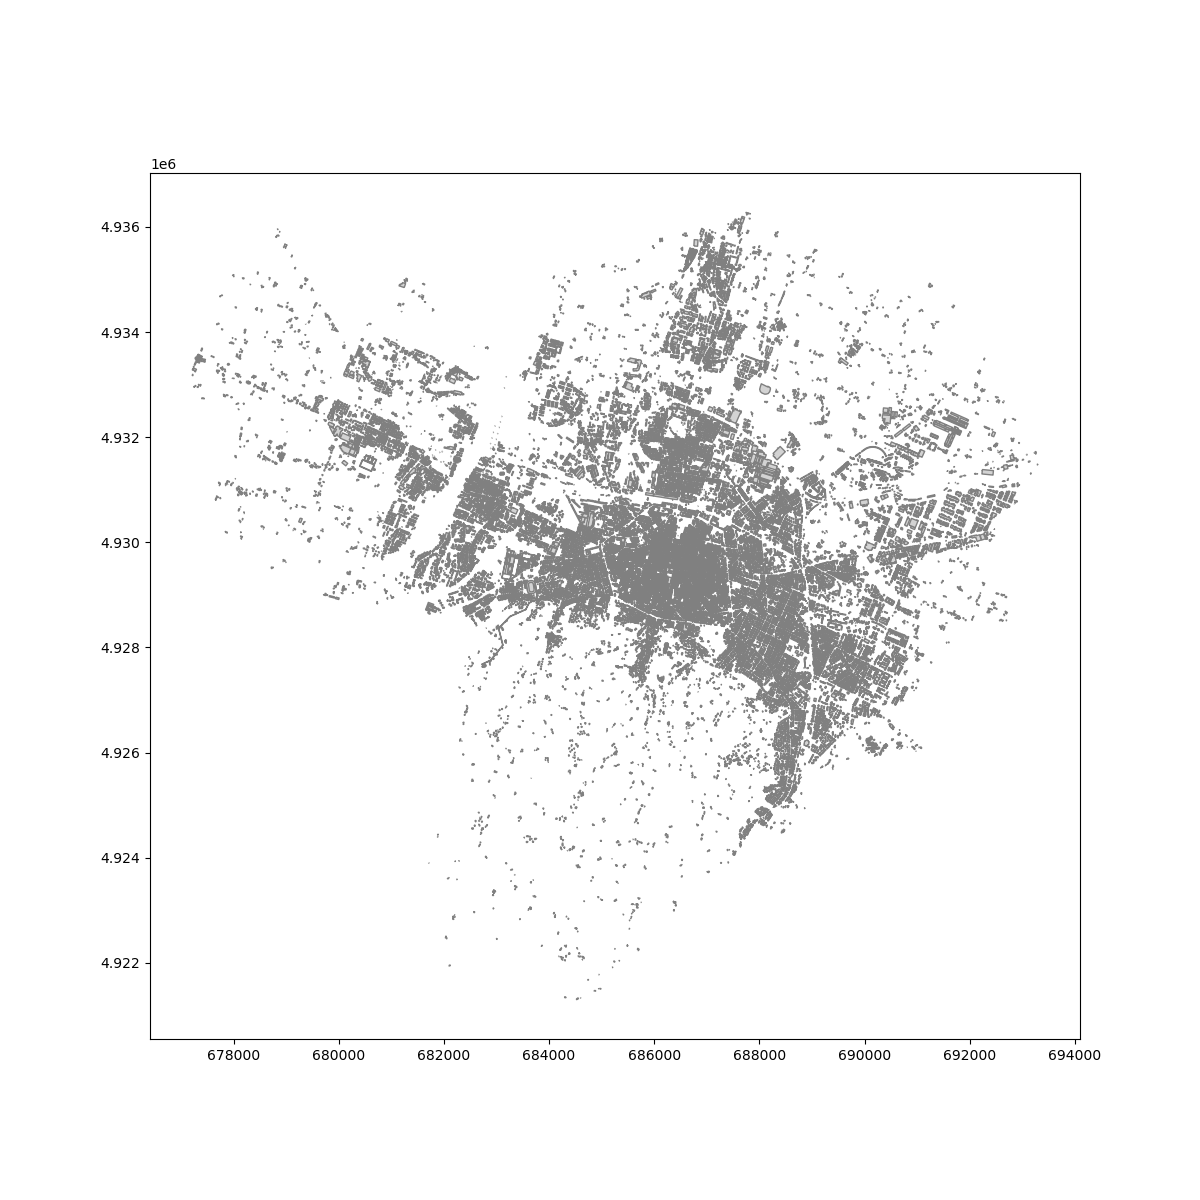

In [5]:
# Plot to verify midpoints per building
fig, ax = plt.subplots(figsize=(12, 12))

# Plot all building footprints in grey
gdf_projected.plot(ax=ax, color='lightgrey', edgecolor='grey')

We store the building data in a GeoDataFrame.

We reproject the data into the EPSG:7791 coordinate system.

We filter out small buildings with an area of less than 10 square meters.

### Calculating Facade Midpoints
We calculate the midpoints of the facades for each building.

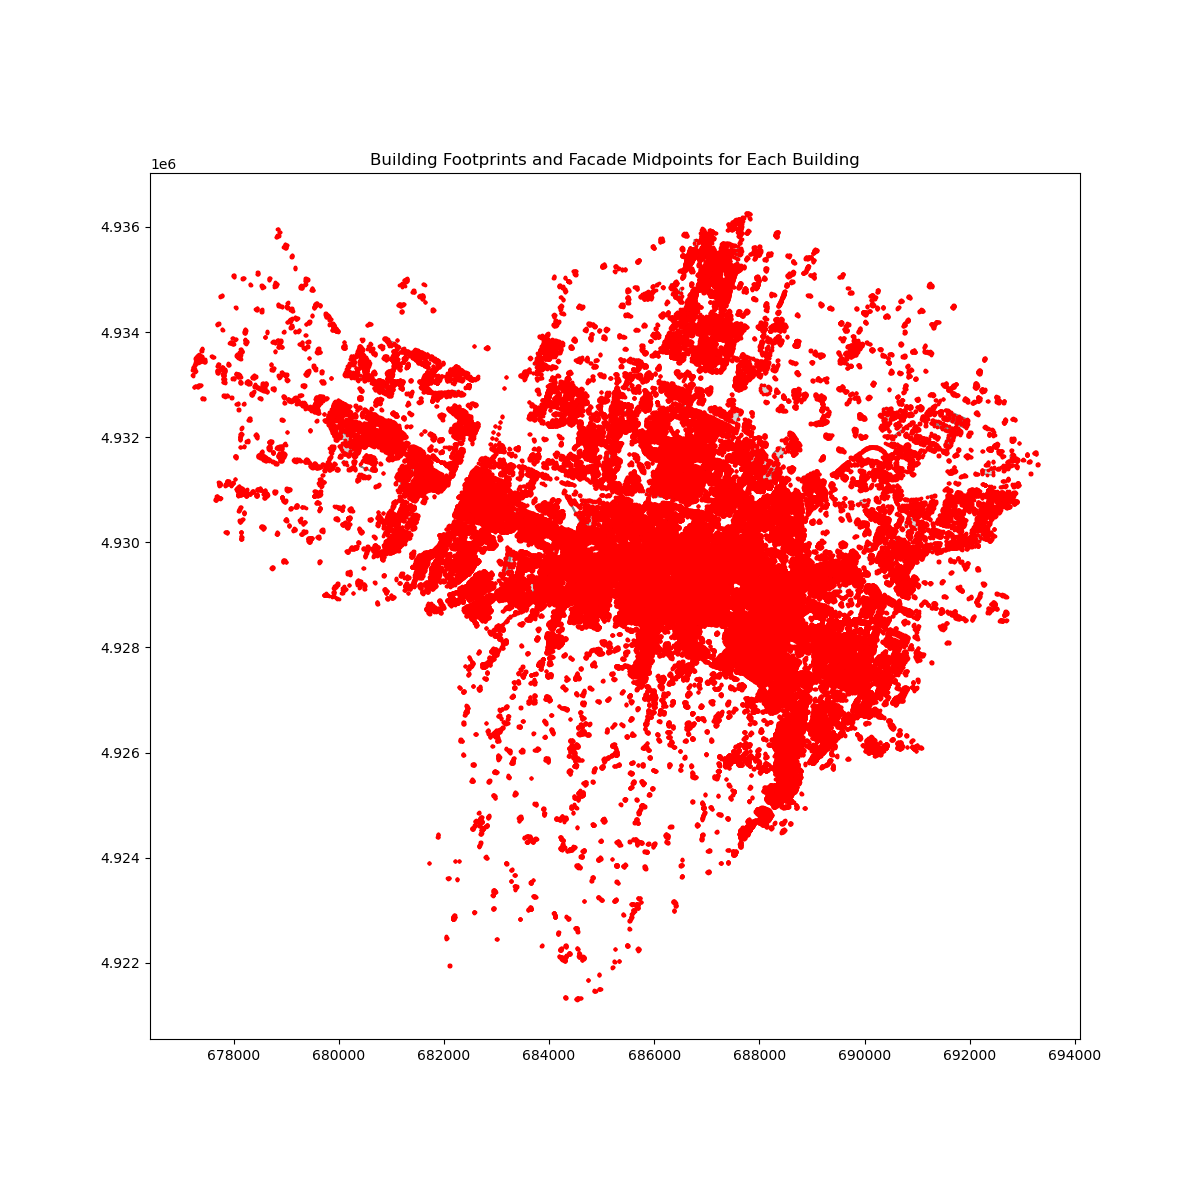

In [6]:
# Process each building footprint separately
facade_midpoints_data = []
for index, row in gdf_projected.iterrows():  # Iterate through rows with index
    building_id = row['osm_id'] if 'osm_id' in gdf_projected.columns else index  # Use OSM ID if available, otherwise use row index
    geometry = row['geometry']
    midpoints = get_facade_midpoints_per_building(geometry, building_id)
    facade_midpoints_data.extend(midpoints)

# Create a GeoDataFrame for facade midpoints
facade_midpoints_gdf = gpd.GeoDataFrame(facade_midpoints_data, crs=gdf_projected.crs)

# Plot to verify midpoints per building
fig, ax = plt.subplots(figsize=(12, 12))

# Plot all building footprints in grey
gdf_projected.plot(ax=ax, color='lightgrey', edgecolor='grey')

# Plot facade midpoints in red
facade_midpoints_gdf.plot(ax=ax, color='red', markersize=3)

plt.title("Building Footprints and Facade Midpoints for Each Building")
plt.show()

This section computes the midpoints of each building facade and stores the results in a new GeoDataFrame.

### Analyzing Grouped Buildings
Here we perform spatial analysis to identify groups of adjacent buildings and find exterior boundaries of these groups.

In [7]:
# Parameters
buffer_distance = 0.1  # For joining buildings
min_segment_length = 1.0  # Minimum length for facade segments

# Use spatial join to find touching buildings
gdf_projected['temp_id'] = gdf_projected.index
gdf_buffered = gdf_projected.copy()
gdf_buffered['geometry'] = gdf_projected.geometry.buffer(buffer_distance)
joined_gdf = gpd.sjoin(gdf_buffered, gdf_buffered, how='inner', predicate='intersects')

# Create the graph from the spatial join results
G = nx.Graph()
for _, row in joined_gdf.iterrows():
    G.add_edge(row['temp_id_left'], row['temp_id_right'])

# Find connected components (groups of adjacent buildings)
connected_components = list(nx.connected_components(G))

# Assign group IDs to buildings based on connected components
gdf_projected['group_id'] = None
for group_id, component in enumerate(connected_components):
    if len(component) == 1:
        gdf_projected.loc[list(component), 'group_id'] = f'standalone_{group_id}'
    else:
        gdf_projected.loc[list(component), 'group_id'] = f'block_{group_id}'

We buffer the buildings slightly to join adjacent buildings and use spatial joins to group them into blocks or groups.

A graph is constructed to represent building adjacency, and connected components (groups) are identified.

### Processing and Plotting Exterior Boundaries and Midpoints
Finally, we plot the exterior boundaries and midpoints of building facades.

In [8]:
# Process each group and identify facade segments along the outer edge, including building IDs
facade_segments = []
exterior_boundaries = []

for group_id, group_gdf in gdf_projected.groupby('group_id'):
    merged_polygon = unary_union(group_gdf['geometry'])
    polygons = list(merged_polygon.geoms) if merged_polygon.geom_type == 'MultiPolygon' else [merged_polygon]

    for polygon in polygons:
        exterior_boundary = polygon.exterior
        exterior_boundaries.append({'group_id': group_id, 'geometry': exterior_boundary})
        
        for i in range(len(exterior_boundary.coords) - 1):
            p1 = exterior_boundary.coords[i]
            p2 = exterior_boundary.coords[i + 1]
            segment = LineString([p1, p2])
            
            if segment.length >= min_segment_length:
                for building_id, building in group_gdf.iterrows():
                    if building['geometry'].intersects(segment):
                        midpoint = segment.centroid
                        facade_segments.append({'group_id': group_id, 'building_id': building_id, 'geometry': midpoint})
                        break

# Create GeoDataFrames for facade segments and exterior boundaries
facade_segments_gdf = gpd.GeoDataFrame(facade_segments, crs=gdf_projected.crs)
exterior_boundaries_gdf = gpd.GeoDataFrame(exterior_boundaries, crs=gdf_projected.crs)

For each group of buildings, we compute the exterior boundary and the midpoints of building facades that are part of this boundary.

In [ ]:
# Save your data as shapefiles and GeoJSONs
data_path = '../data/Street_view/'

# Save as GeoJSON
gdf_projected.to_file(data_path + "Bologna_buildings.geojson", driver="GeoJSON")
exterior_boundaries_gdf.to_file(data_path + "Bologna_exterior_boundaries.geojson", driver="GeoJSON")
facade_segments_gdf.to_file(data_path + "Bologna_facade_segments.geojson", driver="GeoJSON")


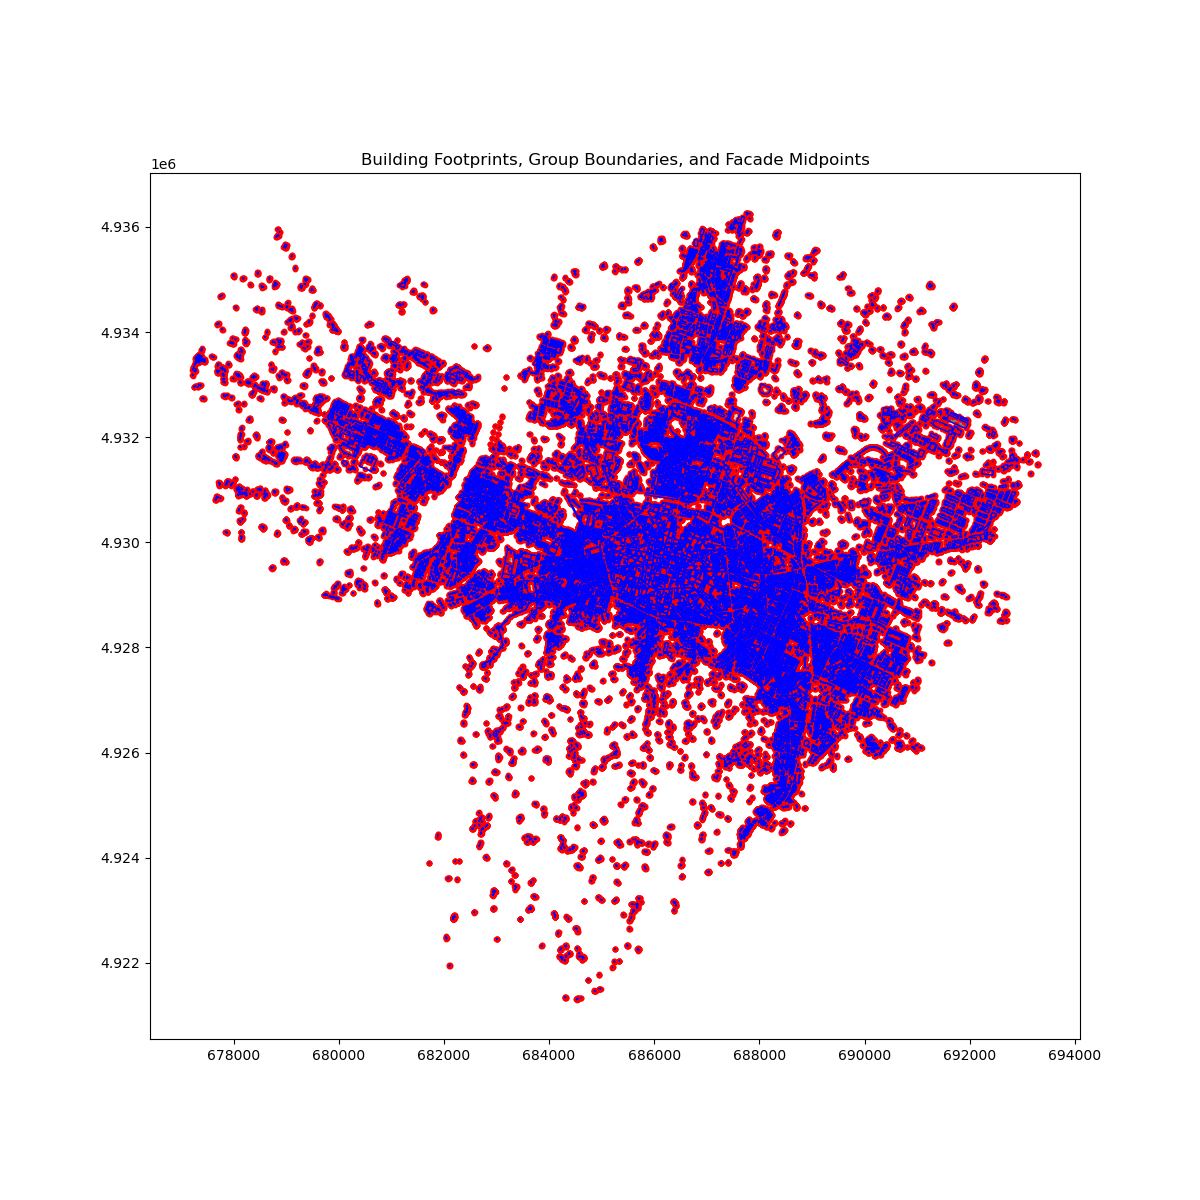

In [10]:
# Plot all buildings, boundaries, and midpoints on one map
fig, ax = plt.subplots(figsize=(12, 12))
gdf_projected.plot(ax=ax, color='lightgrey', edgecolor='grey')
exterior_boundaries_gdf.plot(ax=ax, color='blue', linewidth=1)
facade_segments_gdf.plot(ax=ax, color='red', markersize=10)

#cx.add_basemap(ax, source=cx.providers.OpenStreetMap.Mapnik, zoom=15)
plt.title("Building Footprints, Group Boundaries, and Facade Midpoints")
plt.show()

The final plot shows the buildings, their boundaries, and the calculated facade midpoints.

In [11]:
# Helper function to calculate azimuth between two points
def calculate_azimuth(p1, p2):
    lon1, lat1 = p1
    lon2, lat2 = p2
    # Calculate azimuth as before
    azimuth = math.degrees(math.atan2(lon2 - lon1, lat2 - lat1))
    azimuth = (azimuth + 360) % 360  # Normalize azimuth to [0, 360]

    # Adjust for 90-degree counterclockwise shift
    adjusted_azimuth = (azimuth - 90) % 360

    return adjusted_azimuth


# Function to classify azimuth into cardinal direction with ±45° tolerance
def classify_orientation(azimuth):
    directions = {
        'N': 0,
        'NE': 45,
        'E': 90,
        'SE': 135,
        'S': 180,
        'SW': 225,
        'W': 270,
        'NW': 315
    }
    
    for direction, angle in directions.items():
        if abs(azimuth - angle) <= 45:
            return direction
    return 'N'

# Function to classify azimuth into only N, S, E, W directions with ±45° tolerance
def classify_orientation(azimuth):
    directions = {
        'N': 0,
        'E': 90,
        'S': 180,
        'W': 270
    }
    
    for direction, angle in directions.items():
        if abs(azimuth - angle) <= 45:  # ±45° tolerance for each direction
            return direction
    return 'N'

# Process facade midpoints to assign orientation based on exterior boundaries
def add_orientation_using_exterior_boundaries(facade_segments_gdf, exterior_boundaries_gdf):
    oriented_midpoints = []

    for index, row in facade_segments_gdf.iterrows():
        midpoint = row['geometry']
        group_id = row['group_id']

        # Get the corresponding exterior boundary for this group
        boundary_row = exterior_boundaries_gdf[exterior_boundaries_gdf['group_id'] == group_id]
        if boundary_row.empty:
            continue  # Skip if no matching boundary is found

        boundary = boundary_row.iloc[0]['geometry']  # Get the exterior boundary LINEARRING

        # Iterate over each segment of the exterior boundary
        exterior_coords = list(boundary.coords)
        for i in range(len(exterior_coords) - 1):
            p1 = exterior_coords[i]
            p2 = exterior_coords[i + 1]
            segment = LineString([p1, p2])

            # Check if the midpoint is near the segment (within a small buffer)
            if segment.distance(midpoint) < 1e-6:  # Adjust tolerance as needed
                azimuth = calculate_azimuth(p1, p2)
                orientation = classify_orientation(azimuth)

                # Add the orientation to the midpoint data
                oriented_midpoints.append({
                    'group_id': group_id,
                    'building_id': row['building_id'],
                    'geometry': midpoint,
                    'orientation': orientation
                })
                break  # Once we find the matching segment, we can stop
            
    # Create a new GeoDataFrame with oriented facade midpoints
    oriented_midpoints_gdf = gpd.GeoDataFrame(oriented_midpoints, geometry='geometry', crs=facade_segments_gdf.crs)
    
    return oriented_midpoints_gdf

# Apply the function to classify and add orientation to midpoints based on exterior boundaries
oriented_facade_segments_gdf = add_orientation_using_exterior_boundaries(facade_segments_gdf, exterior_boundaries_gdf)

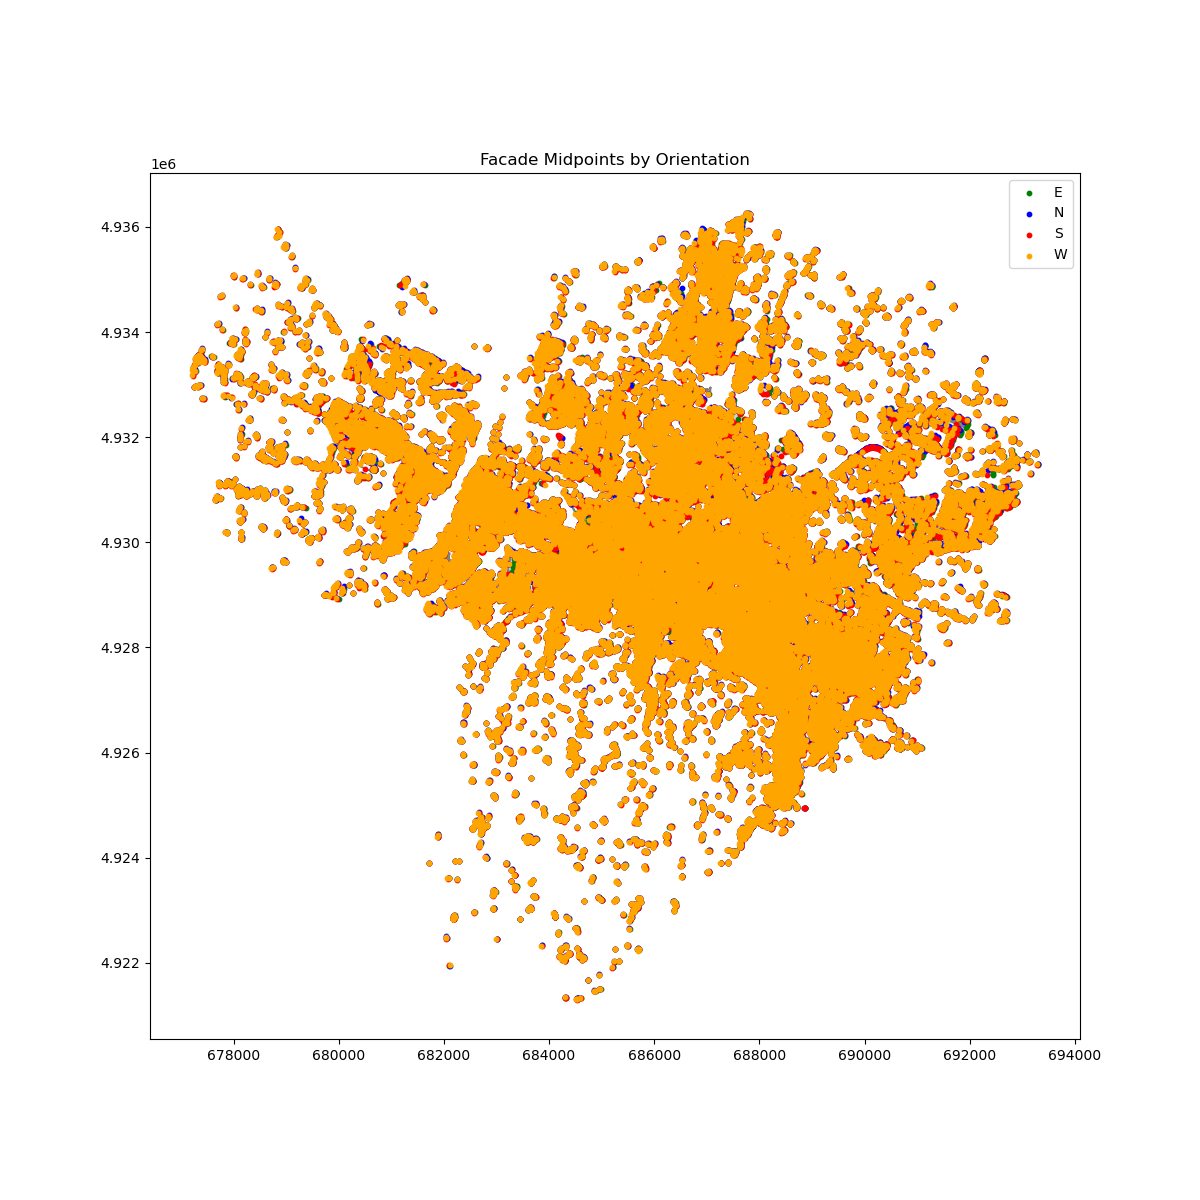

In [12]:
# Plot midpoints grouped by orientation
fig, ax = plt.subplots(figsize=(12, 12))
gdf_projected.plot(ax=ax, color='lightgrey', edgecolor='grey')

# Plot midpoints by orientation, using different colors or markers for each orientation
colors = {'N': 'blue', 'NE': 'cyan', 'E': 'green', 'SE': 'yellow', 'S': 'orange', 'SW': 'red', 'W': 'purple', 'NW': 'pink'}
colors = {'N': 'blue', 'E': 'green', 'S': 'red', 'W': 'orange'}
for orientation, group in oriented_facade_segments_gdf.groupby('orientation'):
    group.plot(ax=ax, color=colors.get(orientation, 'black'), markersize=10, label=orientation)

plt.legend()
plt.title("Facade Midpoints by Orientation")
plt.show()

In [13]:
# Process boundary segments to assign orientation based on exterior boundaries
def add_orientation_to_segments(exterior_boundaries_gdf):
    oriented_segments = []

    for index, row in exterior_boundaries_gdf.iterrows():
        boundary = row['geometry']  # Get the exterior boundary LINEARRING
        group_id = row['group_id']

        # Iterate over each segment of the exterior boundary
        exterior_coords = list(boundary.coords)
        for i in range(len(exterior_coords) - 1):
            p1 = exterior_coords[i]
            p2 = exterior_coords[i + 1]
            segment = LineString([p1, p2])

            # Calculate the azimuth and orientation for the segment
            azimuth = calculate_azimuth(p1, p2)
            orientation = classify_orientation(azimuth)

            # Add the orientation to the boundary segment data
            oriented_segments.append({
                'group_id': group_id,
                'geometry': segment,
                'orientation': orientation
            })

    # Create a new GeoDataFrame with oriented segments
    oriented_segments_gdf = gpd.GeoDataFrame(oriented_segments, geometry='geometry', crs=exterior_boundaries_gdf.crs)
    
    return oriented_segments_gdf

# Apply the function to classify and add orientation to boundary segments
oriented_segments_gdf = add_orientation_to_segments(exterior_boundaries_gdf)

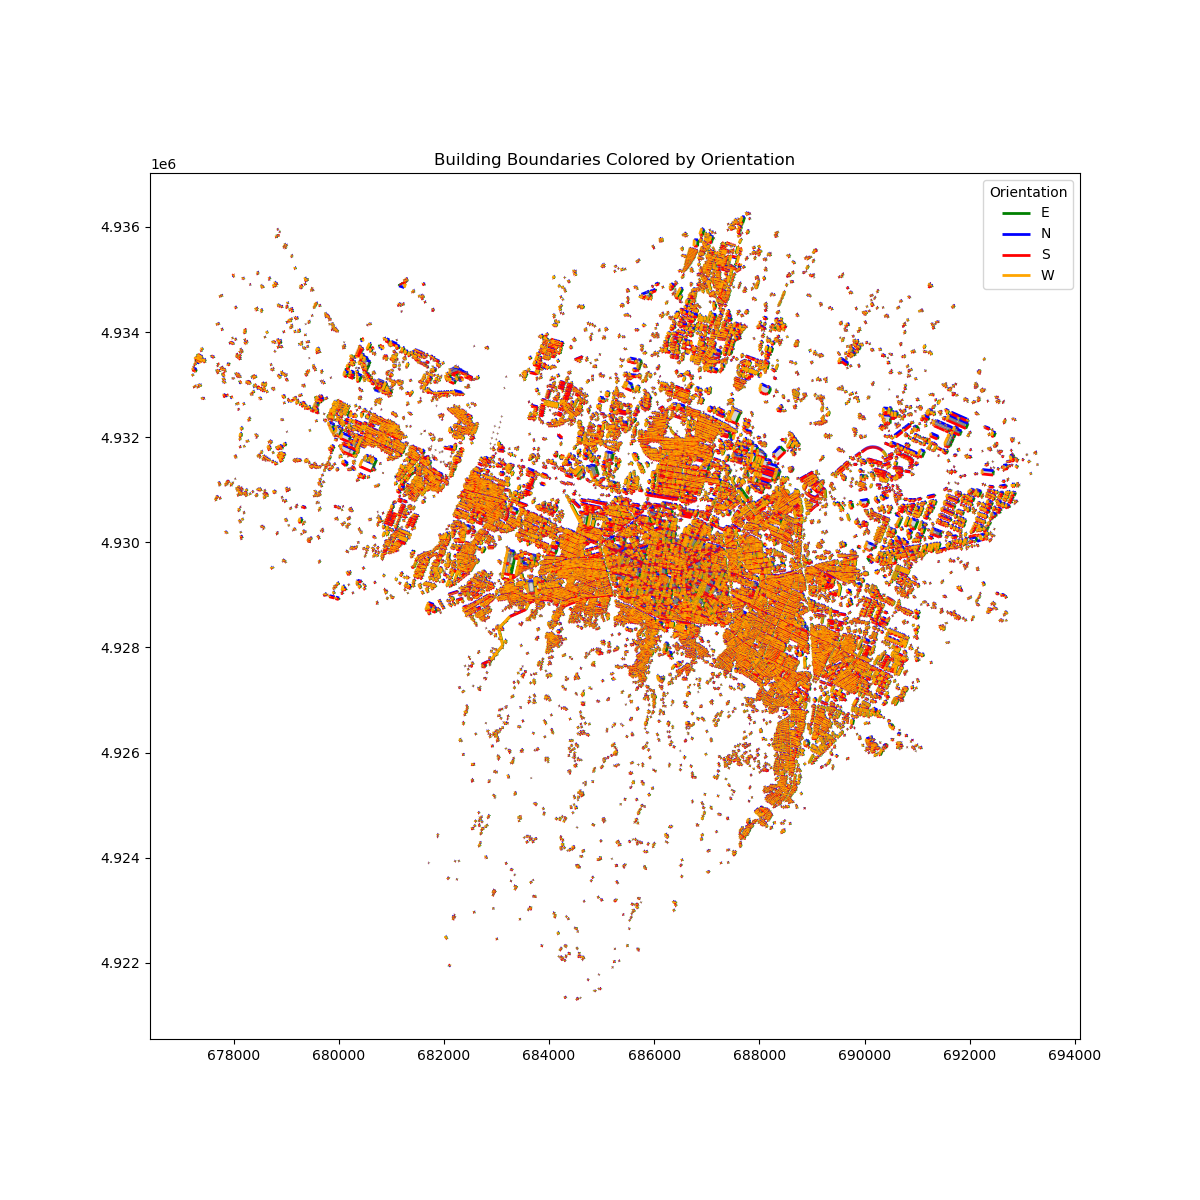

In [14]:
# Plot the segments, coloring by orientation
fig, ax = plt.subplots(figsize=(12, 12))

# Plot buildings or blocks if needed (optional, for context)
gdf_projected.plot(ax=ax, color='lightgrey', edgecolor='grey')

# Plot the oriented segments, color-coded by their orientation
colors = {'N': 'blue', 'E': 'green', 'S': 'red', 'W': 'orange'}
for orientation, group in oriented_segments_gdf.groupby('orientation'):
    group.plot(ax=ax, color=colors[orientation], linewidth=2, label=orientation)

# Add legend
plt.legend(title="Orientation")
plt.title("Building Boundaries Colored by Orientation")
plt.show()

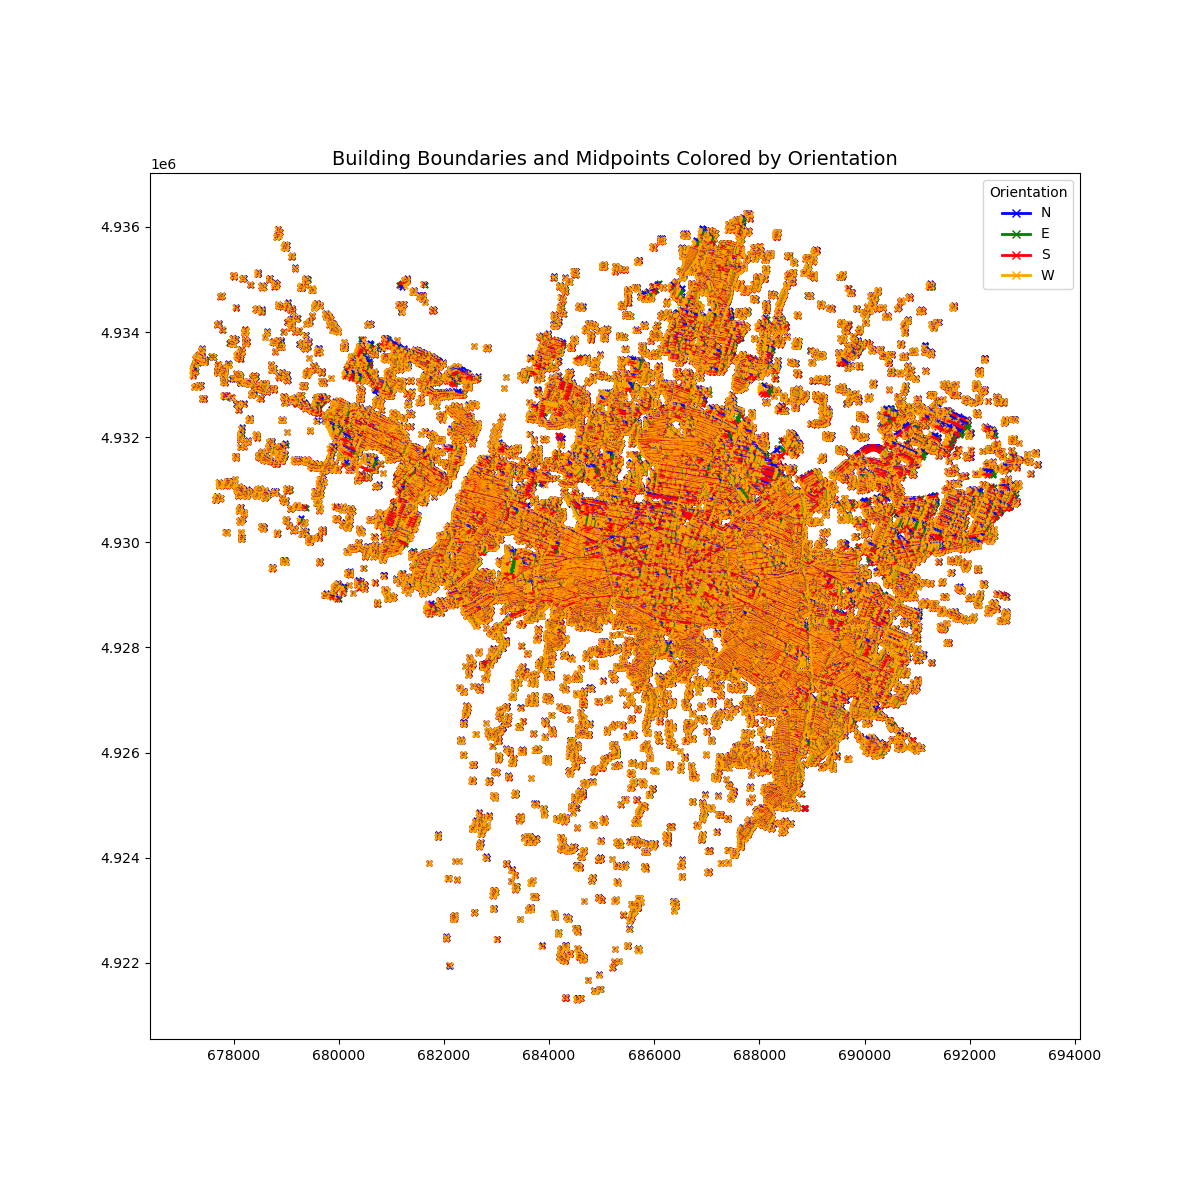

In [15]:
# Plot the segments and midpoints, coloring by orientation
fig, ax = plt.subplots(figsize=(12, 12))

# Plot buildings or blocks for context
gdf_projected.plot(ax=ax, color='lightgrey', edgecolor='grey', alpha=0.7)  # Slight transparency for context

# Define colors for orientations
colors = {'N': 'blue', 'E': 'green', 'S': 'red', 'W': 'orange'}

# Plot the oriented segments (building boundaries) and midpoints together
for orientation, group in oriented_segments_gdf.groupby('orientation'):
    # Plot boundary segments
    group.plot(ax=ax, color=colors[orientation], linewidth=2)
    
    # Plot midpoints with the same color but different marker
    oriented_facade_segments_gdf.groupby('orientation').get_group(orientation).plot(ax=ax, color=colors[orientation], markersize=15, marker='x')

# Add a combined legend only once for both lines and midpoints
legend_labels = [plt.Line2D([0], [0], color=colors[direction], lw=2, marker='x', label=f'{direction}')
                 for direction in colors]
ax.legend(handles=legend_labels, title="Orientation", loc='upper right')

# Improve title and axis display
plt.title("Building Boundaries and Midpoints Colored by Orientation", fontsize=14)

# Show the plot
plt.show()


In [27]:
from tqdm import tqdm
from shapely.ops import nearest_points

# Ensure that building_id in oriented_facade_segments_gdf matches the index type of gdf_projected
oriented_facade_segments_gdf['building_id'] = oriented_facade_segments_gdf['building_id'].astype(gdf_projected.index.dtype)

# Initialize an empty list to store the final results
matched_rows = []

# Iterate over each unique group_id and track progress using tqdm
for group in tqdm(oriented_facade_segments_gdf['group_id'].unique(), desc="Processing Groups"):
    # Select all midpoints and edges for the current group
    group_midpoints = oriented_facade_segments_gdf[oriented_facade_segments_gdf['group_id'] == group]
    group_edges = oriented_segments_gdf[oriented_segments_gdf['group_id'] == group]
    
    # Iterate over each midpoint in the group
    for idx, midpoint_row in group_midpoints.iterrows():
        midpoint = midpoint_row['geometry']  # Get the midpoint geometry
        
        # Find the closest edge to this midpoint
        closest_edge = None
        min_distance = float('inf')
        for _, edge_row in group_edges.iterrows():
            edge = edge_row['geometry']  # Get the edge geometry
            # Calculate the distance between the midpoint and the edge
            distance = midpoint.distance(edge)
            if distance < min_distance:
                min_distance = distance
                closest_edge = edge_row

        # Get the building details from gdf_projected using building_id
        building_id = midpoint_row['building_id']
        building_info = gdf_projected.loc[building_id]  # Now building_id should match the type of gdf_projected's index

        # Add the matched row (midpoint + closest edge + osm_id) to the result
        matched_rows.append({
            'group_id': group,
            'building_id': building_id,
            'osm_id': building_info['osm_id'],  # Get osm_id from gdf_projected
            'geometry_midpoint': midpoint,
            'orientation_midpoint': midpoint_row['orientation'],
            'geometry_outer_edge': closest_edge['geometry'],
            'orientation_outer_edge': closest_edge['orientation']
        })


Processing Groups: 100%|██████████| 22603/22603 [11:34<00:00, 32.56it/s] 


In [20]:
# Create the first GeoDataFrame with geometry_midpoint as the active geometry
gdf_midpoint  = gpd.GeoDataFrame(matched_rows, geometry='geometry_midpoint', crs=oriented_facade_segments_gdf.crs)
# Create the second GeoDataFrame with geometry_outer_edge as the active geometry
gdf_outer_edge  = gpd.GeoDataFrame(matched_rows, geometry='geometry_outer_edge', crs=oriented_facade_segments_gdf.crs)

In [ ]:
# Save gdf_midpoint as GeoJSON
gdf_midpoint.to_file("../data/Street_view/facade_midpoints.geojson", driver="GeoJSON")

# Save gdf_outer_edge as GeoJSON
gdf_outer_edge.to_file("../data/Street_view/facade_outer_edges.geojson", driver="GeoJSON")

In [ ]:
# Save gdf_midpoint as Shapefile
gdf_midpoint.to_file("../data/Street_view/facade_midpoints.shp")

# Save gdf_outer_edge as Shapefile
gdf_outer_edge.to_file("..//Street_view/facade_outer_edges.shp")

C:\Users\FedericoBattini\AppData\Local\Temp\ipykernel_32616\2701981294.py:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_midpoint.to_file("data/Street_view/facade_midpoints.shp")
c:\Users\FedericoBattini\anaconda3\Lib\site-packages\pyogrio\raw.py:709: RuntimeWarning: Normalized/laundered field name: 'building_id' to 'building_i'
  ogr_write(
c:\Users\FedericoBattini\anaconda3\Lib\site-packages\pyogrio\raw.py:709: RuntimeWarning: Normalized/laundered field name: 'orientation_midpoint' to 'orientatio'
  ogr_write(
c:\Users\FedericoBattini\anaconda3\Lib\site-packages\pyogrio\raw.py:709: RuntimeWarning: Normalized/laundered field name: 'geometry_outer_edge' to 'geometry_o'
  ogr_write(
c:\Users\FedericoBattini\anaconda3\Lib\site-packages\pyogrio\raw.py:709: RuntimeWarning: Normalized/laundered field name: 'orientation_outer_edge' to 'orientat_1'
  ogr_write(
C:\Users\FedericoBattini\AppData\Local\Temp\ipykernel_32616\2701981294.